## Imports

In [1]:
import pandas as pd
import sqlalchemy as sa
import sqlite3
import openai
import pyodbc
import pypyodbc as odbc

## Database credentials

In [2]:
''''
server='like4.database.windows.net'
database='like'
connection_string='Driver={ODBC Driver 18 for SQL Server};Server=tcp:like4.database.windows.net,1433;Database=like;Uid=CloudSA42bee827;Pwd={XP2U@X3R5EOQ23};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
conn=odbc.connect(connection_string)
'''

"'\nserver='like4.database.windows.net'\ndatabase='like'\nconnection_string='Driver={ODBC Driver 18 for SQL Server};Server=tcp:like4.database.windows.net,1433;Database=like;Uid=CloudSA42bee827;Pwd={XP2U@X3R5EOQ23};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'\nconn=odbc.connect(connection_string)\n"

In [3]:
''''
sql=''' 
#SELECT count(user_id)
#from dbo.Users 
'''
cursor=conn.cursor()
cursor.execute(sql)
dataset=cursor.fetchall()
print(dataset)
'''

'\ncursor=conn.cursor()\ncursor.execute(sql)\ndataset=cursor.fetchall()\nprint(dataset)\n'

## Connecting to the data warehouse

In [4]:
f = open("Credintials.txt", "r")
email = None
password = None
for i, line in enumerate(f):
    if i == 0:
        email = line.strip()  # Assign the first line to email variable
    elif i == 1:
        password = line.strip()  # Assign the second line to password variable

f.close()

In [5]:
server = 'anmx3c2yurjethctgyba6xtuaq-vkvbn7t4322edeguc3ufhjtjeu.datawarehouse.pbidedicated.windows.net'
database = 'likeCard'
driver='ODBC Driver 18 for SQL Server'
user= email # use %40 inplace of @
pass1=password # use %40 inplace of @   

# Create a connection string for SQL Server using Windows authentication
connection_string = f'mssql+pyodbc://{user}:{pass1}@{server}/{database}?driver={driver}&Trusted_Connection=no&Authentication=ActiveDirectoryInteractive'

In [6]:
engine = sa.create_engine(connection_string, echo=True, connect_args={'autocommit': True}, fast_executemany=True)


## Data Preprocessing

In [7]:
sql_query = '''
SELECT 
    TABLE_SCHEMA,
    TABLE_NAME,
    COLUMN_NAME,
    DATA_TYPE
FROM 
    INFORMATION_SCHEMA.COLUMNS
WHERE 
    TABLE_NAME IN (SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE')
    and TABLE_NAME like 'dim_product' 
    or TABLE_NAME like 'fact_trans%' 
    
'''
df = pd.read_sql(sql_query, engine)

2024-01-08 17:33:28,953 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2024-01-08 17:33:28,953 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-08 17:33:29,202 INFO sqlalchemy.engine.Engine SELECT schema_name()
2024-01-08 17:33:29,202 INFO sqlalchemy.engine.Engine [generated in 0.00203s] ()
2024-01-08 17:33:29,786 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2024-01-08 17:33:29,786 INFO sqlalchemy.engine.Engine [generated in 0.00257s] ()
2024-01-08 17:33:30,105 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2024-01-08 17:33:30,105 INFO sqlalchemy.engine.Engine [generated in 0.00273s] ('BASE TABLE', "\nSELECT \n    TABLE_

In [8]:
table_schema=df.loc[0][0]

In [9]:
print(table_schema)

dbo


In [10]:
df=df.drop(columns=['TABLE_SCHEMA'])


In [11]:
df.columns

Index(['TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE'], dtype='object')

In [12]:
df_dict = df.to_dict(orient='records')
df_dict

[{'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'OrderDateTime',
  'DATA_TYPE': 'datetime2'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'user_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'order_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'store_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'payment_method_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'bank_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'product_id',
  'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions', 'COLUMN_NAME': 'qty', 'DATA_TYPE': 'int'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'cost',
  'DATA_TYPE': 'float'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'coupon_code',
  'DATA_TYPE': 'varchar'},
 {'TABLE_NAME': 'fact_transactions',
  'COLUMN_NAME': 'fees',
  'DATA_TYPE': 'float'},
 {'TABL

In [13]:
unique_table_names = set(entry['TABLE_NAME'] for entry in df_dict)

# Display unique table names
for table_name in unique_table_names:
    print(table_name)


fact_transactions


In [14]:
openai.api_type = "azure"
openai.api_base = "https://like-card-test.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = "85889c7998dd4adb9a4c89abe56b1242" 
openai.azure_endpoint="https://like-card-test.openai.azure.com/openai/deployments/gpt-35-turbo-instruct/chat/completions?api-version=2023-07-01-preview"

In [15]:
query = None
def generate_sql_query(dictionary, text, table_schema):
    prompt = """You are a SQL query writer capable of generating concise SQL server queries. 
    Provide a natural language input text, and I will generate the corresponding SQL query using only function calls and parentheses. 
    Replace descriptive words with SQL functions, for example, replace DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY) with DATE_SUB(CURRENT_DATE(), 1).
    The tables, columns, and data types are specified in this dictionary: {}.
    The tables follow the schema: {}.
    Input: {} SQL Query (without descriptive words).
    Note: You have multiple tables, so join the necessary tables as needed.
    """.format(dictionary, table_schema, text)

    request = openai.ChatCompletion.create(
        engine="gpt-35-turbo",
        messages=[
            {"role": "user", "content": prompt},
        ]
    )
    global query
    query = request.choices[0].message.content
    return query


In [16]:
def executeSQLquery(df_dict,text,table_schema ,max_retries):
    retry_count = 0
    
    while retry_count < max_retries:
        try:
            query = generate_sql_query(df_dict,text,table_schema)
            result = pd.read_sql(query,engine)
            return result
        except Exception as e:
            print(f"Error executing query: {e}")
            retry_count += 1
            if retry_count < max_retries:
                print(f"Retrying... (Attempt {retry_count}/{max_retries})")
            else:
                print("Max retry attempts reached. Exiting.")
                raise

In [17]:
def get_result_prompt(question,query,df_dict,table_schema,queryResult):

    prompt = """I want you to answer the input question based on the table schema ,
    column name , column data type,input sql query where you can join between tables,
    if the input result is empty then return the output as 'No data found', You should not tell about sql query and tables in the result, 
    If something wrong then return 'Try it in another way'. tables schema are: {}, input SQL is: {}, query result is :{}
    and the input question is: {}. The output should be in natural language text.""".format(table_schema,query,queryResult,question)
    return prompt
text = 'top 5 product_id that new customers purchase'
queryResult = executeSQLquery(df_dict,text,table_schema ,6)
result_prompt = get_result_prompt(text,query,df_dict,table_schema,queryResult)

2024-01-08 17:34:23,249 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2024-01-08 17:34:23,255 INFO sqlalchemy.engine.Engine [cached since 53.15s ago] ('BASE TABLE', 'SELECT TOP 5 product_id\nFROM dbo.fact_transactions\nJOIN dbo.dim_customers ON fact_transactions.user_id = dim_customers.user_id\nWHERE dim_customers.is_new_customer = 1', 'dbo')
2024-01-08 17:34:23,855 INFO sqlalchemy.engine.Engine SELECT TOP 5 product_id
FROM dbo.fact_transactions
JOIN dbo.dim_customers ON fact_transactions.user_id = dim_customers.user_id
WHERE dim_customers.is_new_customer = 1
2024-01-08 17:34:23,855 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-08 17:34:24,152 INFO sqlalchemy.engine.Engine ROLLBACK
Error e

In [19]:
request = openai.ChatCompletion.create(
        engine="gpt-35-turbo",
        messages=[
            {"role": "user", "content": result_prompt},
        ]
    )
answer = request.choices[0].message.content
print(answer)

The top 5 product IDs that new customers have purchased are 919, 5215, 103, 434, and 58.


In [22]:
def graph(question,query,df_dict,table_schema,queryResult):

    prompt = """**Task:** Write Python code using pandas and matplotlib **without any comments** to generate the graph based on the provided data.

**Context:**
- Table schema: {}
- Input SQL query (with potential joins): {}
- Query result: {}
- Input question: {}

**Requirements:**
- Handle empty results with "No data found."
- Gracefully handle errors with "Try it in another way."

**Example:**
> import pandas as pd
> import matplotlib.pyplot as plt
> 
> # ...
> ```
""".format(table_schema, query, queryResult, question)


    request = openai.ChatCompletion.create(
        engine="gpt-35-turbo",
        messages=[
            {"role": "user", "content": prompt},
        ]
    )
    answer = request.choices[0].message.content
    return answer
graph_code = graph(text,query,df_dict,table_schema,queryResult)
graph_code

'import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = {\n    \'product_id\': [919, 5215, 103, 434, 58]\n}\n\ntry:\n    df = pd.DataFrame(data)\n    \n    if df.empty:\n        print("No data found.")\n    else:\n        plt.bar(df.index, df[\'product_id\'])\n        plt.xlabel(\'Index\')\n        plt.ylabel(\'Number of Purchases\')\n        plt.title(\'Top 5 Product IDs Purchased by New Customers\')\n        plt.show()\n\nexcept:\n    print("Try it in another way.")'

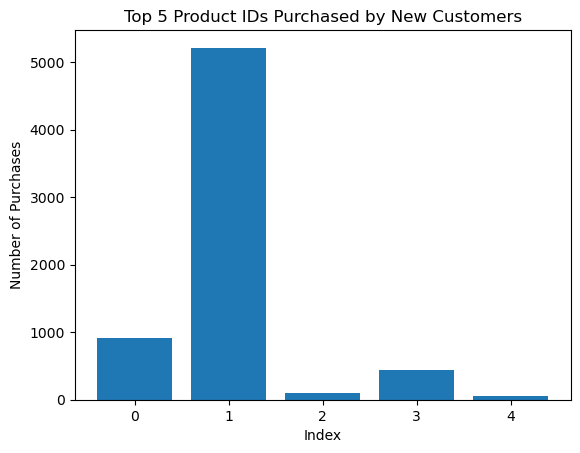

In [23]:
exec(graph_code)